In [1]:
#imports
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
%matplotlib inline

### Idea behind building your own dataset and dataloader:
You have to create a dataset class in which you have to define 3 functions:
* __init__() : Here you'll specify the attributes for the dataset class like labels,classes, path etc..
* __len__() : This function should return the number of images in a batch
* __getitem__() : This function dictates how the object should behave when you index into it. It should return an image and it's label

### Explaining the folder structure

* All your images are in one folder that you'll pass as data_folder
* All the labels for the images are in a file called labels.csv
* directory structure: data_folder and labels.csv are inside root_dir
* index: for training/validation purpose...it should be a list of indices

In [33]:
#sample label file
pd.read_csv('nih_label_normal_condition.csv').head(2)

,id,classes
0,00000001_000.png,condition
1,00000001_001.png,condition


### Dataset class

In [2]:
class Dataset_from_csv():
    def __init__(self, label_file, root_dir, data_folder,transform,index):
        """
        Args:
            label_file (string): Name of the label file which contains id,class.
            root_dir (string): Directory which contains the labels file and data folder.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            data_folder(string): name of the folder containing the images
            index (list): list of indices to pick from the labels file. It's useful when you have to pick train and validation
        """ 
        self.root_dir = root_dir
        self.index = index
        self.labels = pd.read_csv(f'{root_dir}{label_file}').iloc[self.index]
        self.classes, self.class_to_idx = self.find_classes()
        self.data_folder = data_folder
        self.imgs = self.make_dataset()
        self.transform = transform
        
    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        path,target = self.imgs[idx]
        img = self.pil_loader(path) #loading the image using PIL
        if self.transform is not None:
            img = self.transform(img)
        return img, target
    
    def find_classes(self):
        classes = list(self.labels.iloc[:,1].unique()) #finding unique classes in the labels file
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))} #creating an integer id for each class
        return classes, class_to_idx

    def make_dataset(self):
        path = self.labels.iloc[:,0].apply(lambda x: os.path.join(self.root_dir,self.data_folder,x)) #creating full path to each image
        target = self.labels.iloc[:,1].apply(lambda x: self.class_to_idx[x]) #storing targets for each image file
        images = list(zip(path,target))
        return images
    
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB') 



### Transforms

In [6]:
# Specify the different kinds of transforms you want to apply
transform = transforms.Compose([
#     transforms.RandomSizedCrop(290),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

### Train-Validation indices

In [4]:
#Specify the indexes for train and validation data which will used while indexing from the label file
train_idx = list(range(1000))
val_idxs = list(range(1001,2000))

### Batch size

In [5]:
batch_size = 4 #this is required in dataloader function

### Creating dataloaders for train and validation

In [6]:
train = Dataset_from_csv(data_folder='images_transform/',index=train_idx,label_file='nih_label_normal_condition.csv',transform=transform,root_dir='data/')
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

In [7]:
valid = Dataset_from_csv(data_folder='images_transform/',index=val_idxs,label_file='nih_label_normal_condition.csv',transform=transform,root_dir='data/')
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

### Testing

In [8]:
xmb,ymb = next(iter(train_loader))

In [9]:
xmb.shape # Batch of 4 images with size of 1024*1024 and 3 channels (RGB)

torch.Size([4, 3, 1024, 1024])

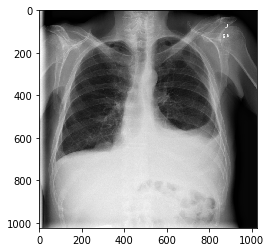

In [11]:
plt.imshow(np.swapaxes(np.swapaxes(xmb[0].numpy(),0,2),0,1))